# Imports

In [1]:
import os
import copy
import re
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import nltk
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt

from tqdm import tqdm

# Constants

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

GLOVE_DIR = '../input/glove-global-vectors-for-word-representation'
GLOVE_DIMS = [50, 100, 200]

DATA_DIR = '../input/nlp-getting-started'
TRAIN_PATH = os.path.join(DATA_DIR, 'train.csv')
TEST_PATH = os.path.join(DATA_DIR, 'test.csv')

PAD_TOKEN = '<PAD>'
UNK_TOKEN = '<UNK>'
UNK_THRESHOLD = 2

VAL_SIZE = 0.1
BATCH_SIZE = 4
VAL_BATCH_SIZE = 2

HIDDEN_DIM = 256
RNN_LAYERS = [1, 2, 3]

LEARNING_RATE = 0.0001
MAX_EPOCHS = 10

SEED = 573
if SEED:
    np.random.seed(SEED)
    torch.manual_seed(SEED)

cuda


# Utilities

In [3]:
def tokenize(text):
    text = text.lower().strip()
    text = re.sub(r'[^\w\s]', '', text) 
    text = re.sub(r'http\S+', '', text)
    text = re.sub('\n', '', text)
    return word_tokenize(text)

In [4]:
def get_embedding_matrix(tok2ind, tok2emb, dim):
    embedding_matrix = np.zeros((len(tok2ind), dim))
    freeze_indices = []

    for token, index in tok2ind.items():
        if token in tok2emb:
            embedding_matrix[index] = tok2emb[token]
            freeze_indices.append(index)
        else:
            embedding_matrix[index] = np.random.normal(size=dim)
    
    return embedding_matrix, freeze_indices

In [5]:
def get_accuracy(true_labels, pred_labels):
    assert len(true_labels) == len(pred_labels)
    return np.sum(np.equal(true_labels, pred_labels)) / len(true_labels)

In [6]:
def get_precision_and_recall(true_labels, pred_labels, target_label,
                             other_label):
    assert len(true_labels) == len(pred_labels)
    true_positive_count = np.sum([1 if true_labels[i] == target_label and
                                  pred_labels[i] == target_label else 0
                                  for i in range(len(true_labels))])
    false_positive_count = np.sum([1 if true_labels[i] == other_label and
                                   pred_labels[i] == target_label else 0
                                   for i in range(len(true_labels))])
    false_negative_count = np.sum([1 if true_labels[i] == target_label and
                                   pred_labels[i] == other_label else 0
                                   for i in range(len(true_labels))])

    precision = true_positive_count / (true_positive_count +
                                       false_positive_count)
    recall = true_positive_count / (true_positive_count +
                                    false_negative_count)

    return precision, recall

In [7]:
def get_f1_score(precision, recall):
    return 2 * precision * recall / (precision + recall)

# Training and Evaluation

In [8]:
def train(model, dataloader, optimizer, freeze_indices=[]):
    running_loss = 0.0
    running_corrects = 0
    
    for data, labels in tqdm(dataloader):
        data, labels = data.to(DEVICE), labels.to(DEVICE)

        out = model(data)
        pred = out.argmax(dim=1)
        loss = F.cross_entropy(out, labels)
        
        model.zero_grad()
        loss.backward()

        model.encoder.weight.grad[freeze_indices] = 0
        
        optimizer.step()
        
        running_loss += loss.item() * data.size(0)
        running_corrects += torch.sum(pred == labels.data)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    
    return epoch_loss, epoch_acc

In [9]:
def evaluate(model, dataloader):
    all_preds = []
    all_labels = []
    running_loss = 0.0

    with torch.no_grad():
        for data, labels in tqdm(dataloader):
            data, labels = data.to(DEVICE), labels.to(DEVICE)
            out = model(data)
            pred = out.argmax(dim=1)
            loss = F.cross_entropy(out, labels)
            running_loss += loss.item() * data.size(0)
            all_preds.extend(pred.tolist())
            all_labels.extend(labels.tolist())

    accuracy = get_accuracy(all_labels, all_preds)
    loss = running_loss / len(dataloader.dataset)
    precision_pos, recall_pos = get_precision_and_recall(all_labels, all_preds,
                                                         1, 0)
    f1_score_pos = get_f1_score(precision_pos, recall_pos)
    precision_neg, recall_neg = get_precision_and_recall(all_labels, all_preds,
                                                         0, 1)
    f1_score_neg = get_f1_score(precision_neg, recall_neg)
    f1_score_macro = (f1_score_pos + f1_score_neg) / 2

    return accuracy, loss, f1_score_macro

In [10]:
def get_predictions(model, dataloader):
    all_preds = []
    
    with torch.no_grad():
        for data, _ in tqdm(dataloader):
            data = data.to(DEVICE)
            out = model(data)
            pred = out.argmax(dim=1)
            all_preds.extend(pred.tolist())
    
    return all_preds

# GLoVe

In [11]:
class GloVe:

    def __init__(self, dim, glove_dir=GLOVE_DIR, pad_token=PAD_TOKEN,
                 unk_token=UNK_TOKEN):
        self.dim = dim
        self.pad_token = pad_token
        self.unk_token = unk_token
        self.tok2emb = {
            self.pad_token: np.random.normal(size=self.dim),
            self.unk_token: np.random.normal(size=self.dim)
        }
        with open(os.path.join(glove_dir, 'glove.6B.{}d.txt'.format(dim)), 'r') as f:
            for line in f:
                line = line.split()
                self.tok2emb[line[0]] = np.array(line[1:], dtype=np.float64)

# Data

In [12]:
class TweetData:
    
    def __init__(self, val_size=VAL_SIZE, pad_token=PAD_TOKEN, unk_token=UNK_TOKEN, unk_threshold=UNK_THRESHOLD):
        self.val_size = val_size
        self.pad_token = pad_token
        self.unk_token = unk_token
        self.unk_threshold = unk_threshold

        tweets = self._get_tweets()
        self.train_data, self.val_data = self._train_val_split(tweets)
        self.test_data = self._get_test_data()
        
        self.tok2ind, self.ind2tok = self._construct_vocab()
        self._apply_vocab()
    
    def _get_tweets(self):
        tweets = []
        df = pd.read_csv(TRAIN_PATH)
        for i in range(len(df)):
            tweets.append({
                'label': int(df['target'].values[i]),
                'tokens': tokenize(df['text'].values[i])
            })
        return tweets
    
    def _get_test_data(self):
        test = []
        df = pd.read_csv(TEST_PATH)
        for i in range(len(df)):
            test.append({
                'label': -1, # -1 since no labels are in the test set
                'tokens': tokenize(df['text'].values[i])
            })
        return test
    
    def _train_val_split(self, tweets):
        np.random.shuffle(tweets)
        train_length = len(tweets) - int(len(tweets) * self.val_size)
        return tweets[:train_length], tweets[train_length:]
    
    def _construct_vocab(self):
        token_freqs = {}
        for tweet in self.train_data:
            for token in tweet['tokens']:
                token_freqs[token] = token_freqs.get(token, 0) + 1
        
        tok2ind = {
            self.pad_token: 0,
            self.unk_token: 1
        }
        ind2tok = [self.pad_token, self.unk_token]
        for token, freq in token_freqs.items():
            if freq >= self.unk_threshold:
                tok2ind[token] = len(ind2tok)
                ind2tok.append(token)
        return tok2ind, ind2tok
    
    def _apply_vocab(self):
        for tweets in (self.train_data, self.val_data, self.test_data):
            for i in range(len(tweets)):
                tweets[i]['mapped_tokens'] = [self.tok2ind.get(token, self.tok2ind[self.unk_token])
                                              for token in tweets[i]['tokens']]

# Dataset

In [13]:
class TweetDataset(Dataset):

    def __init__(self, tweets, pad_ind):
        self.pad_ind = pad_ind
        self.data = [tweet['mapped_tokens'] for tweet in tweets]
        self.labels = [tweet['label'] for tweet in tweets]
    
    def __getitem__(self, ind):
        return [self.data[ind], self.labels[ind]]
    
    def __len__(self):
        return len(self.data)
    
    def _collate_fn(self, batch):
        data, labels = zip(*batch)

        batch_data = []
        max_data_len = 0
        for d in data:
            batch_data.append(torch.tensor(d, dtype=torch.long))
            max_data_len = max(max_data_len, len(batch_data[-1]))
        for i in range(len(batch_data)):
            batch_data[i] = F.pad(batch_data[i],
                                  (0, max_data_len - len(batch_data[i])),
                                  value=self.pad_ind)

        batch_labels = [torch.tensor(label, dtype=torch.long)
                        for label in labels]
        
        return [torch.stack(batch_data), torch.stack(batch_labels)]

# Classifier

In [14]:
class DisasterModel(nn.Module):

    def __init__(self, vocab_size, embedding_matrix, pad_ind,
                 embedding_dim, rnn_layers, hidden_dim=HIDDEN_DIM):
        super().__init__()

        self.pad_ind = pad_ind
        self.encoder = nn.Embedding(vocab_size, embedding_dim)
        with torch.no_grad():
            self.encoder.weight.copy_(torch.from_numpy(embedding_matrix))
        self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=rnn_layers,
                          batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * rnn_layers * 2, 2) # 2 possible labels
    
    def forward(self, x):
        true_lens = (x != self.pad_ind).sum(dim=1).cpu()
        x1 = self.encoder(x)
        x2 = nn.utils.rnn.pack_padded_sequence(x1, true_lens, batch_first=True,
                                               enforce_sorted=False)
        x3, hidden = self.rnn(x2)
        hidden = hidden.transpose(0, 1).reshape(hidden.shape[1],
                                                hidden.shape[0] * hidden.shape[2])
        y = self.fc(hidden)
        return y

# Main

In [15]:
tweet_data = TweetData()

In [16]:
pad_ind = tweet_data.tok2ind[PAD_TOKEN]
train_dataset = TweetDataset(tweet_data.train_data, pad_ind)
val_dataset = TweetDataset(tweet_data.val_data, pad_ind)
test_dataset = TweetDataset(tweet_data.test_data, pad_ind)

In [17]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True,
                              collate_fn=train_dataset._collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE,
                            collate_fn=val_dataset._collate_fn)
test_dataloader = DataLoader(test_dataset, collate_fn=test_dataset._collate_fn)

In [18]:
models = {}
train_accs = {}
train_ls = {}
val_accs = {}
val_ls = {}

for glove_dim in GLOVE_DIMS:
    glove = GloVe(glove_dim)
    embedding_matrix, freeze_indices = get_embedding_matrix(tweet_data.tok2ind, glove.tok2emb, glove_dim)
                  
    models[glove_dim] = {}
    train_accs[glove_dim] = {}
    train_ls[glove_dim] = {}
    val_accs[glove_dim] = {}
    val_ls[glove_dim] = {}
    
    for rnn_layers in RNN_LAYERS:
        print('GloVe dimension: {}\tRNN layers: {}'.format(glove_dim, rnn_layers))
                  
        model = DisasterModel(len(tweet_data.tok2ind), embedding_matrix,
                              pad_ind, glove_dim, rnn_layers).to(DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
                  
        accuracy, loss, f1_score = evaluate(model, val_dataloader)
        val_accuracies = [accuracy]
        val_f1_scores = [f1_score]
        val_losses = [loss]
                  
        accuracy, loss, _ = evaluate(model, train_dataloader)
        train_accuracies = [accuracy]
        train_losses = [loss]
                  
        best_model_state_dict = copy.deepcopy(model.state_dict())
        best_val_acc = val_accuracies[0]

        for epoch in range(MAX_EPOCHS):
            print('Epoch {}'.format(epoch + 1))

            train_loss, train_accuracy = train(model, train_dataloader, optimizer)
            accuracy, loss, f1_score = evaluate(model, val_dataloader)

            print('Train Accuracy: {}'.format(train_accuracy))
            print('Train Loss: {}'.format(train_loss))
            print()
            print('Val Accuracy: {}'.format(accuracy))
            print('Val Loss: {}'.format(loss))
            print('Val Macro-Averaged F1-Score: {}'.format(f1_score))
            print()

            train_accuracies.append(train_accuracy.cpu())
            train_losses.append(train_loss)
            val_accuracies.append(accuracy)
            val_losses.append(loss)
            val_f1_scores.append(f1_score)

            if accuracy > best_val_acc:
                best_val_acc = accuracy
                best_model_state_dict = copy.deepcopy(model.state_dict())

        print('GloVe dimension: {}\tRNN layers: {}\t Best Validation Accuracy: {}'.format(glove_dim, rnn_layers, best_val_acc))
        
        model.load_state_dict(best_model_state_dict)
                  
        models[glove_dim][rnn_layers] = model
        train_accs[glove_dim][rnn_layers] = train_accuracies
        train_ls[glove_dim][rnn_layers] = train_losses
        val_accs[glove_dim][rnn_layers] = val_accuracies
        val_ls[glove_dim][rnn_layers] = val_losses

GloVe dimension: 50	RNN layers: 1


100%|██████████| 1713/1713 [00:04<00:00, 410.96it/s]


Epoch 1


100%|██████████| 381/381 [00:00<00:00, 659.66it/s]


Train Accuracy: 0.7678050204319906
Train Loss: 0.49187657345353825

Val Accuracy: 0.7766097240473062
Val Loss: 0.46727005569766056
Val Macro-Averaged F1-Score: 0.7713890891612594

Epoch 2


100%|██████████| 381/381 [00:00<00:00, 685.22it/s]


Train Accuracy: 0.8012259194395797
Train Loss: 0.4398812655200752

Val Accuracy: 0.783180026281209
Val Loss: 0.46225180386831194
Val Macro-Averaged F1-Score: 0.7787233217671119

Epoch 3


100%|██████████| 381/381 [00:00<00:00, 688.56it/s]


Train Accuracy: 0.8161120840630472
Train Loss: 0.41758213808539313

Val Accuracy: 0.7766097240473062
Val Loss: 0.4622913679284253
Val Macro-Averaged F1-Score: 0.769127262863343

Epoch 4


100%|██████████| 381/381 [00:00<00:00, 679.04it/s]


Train Accuracy: 0.8226795096322241
Train Loss: 0.3988209852157188

Val Accuracy: 0.78580814717477
Val Loss: 0.4588043780730604
Val Macro-Averaged F1-Score: 0.7771499817649712

Epoch 5


100%|██████████| 381/381 [00:00<00:00, 701.13it/s]


Train Accuracy: 0.8369819030939871
Train Loss: 0.3798692528472673

Val Accuracy: 0.7923784494086727
Val Loss: 0.4490897196856586
Val Macro-Averaged F1-Score: 0.787351971589864

Epoch 6


100%|██████████| 381/381 [00:00<00:00, 559.69it/s]


Train Accuracy: 0.8460303561004087
Train Loss: 0.36434743993100643

Val Accuracy: 0.7950065703022339
Val Loss: 0.46647333394939205
Val Macro-Averaged F1-Score: 0.7868347338935575

Epoch 7


100%|██████████| 381/381 [00:00<00:00, 484.91it/s]


Train Accuracy: 0.8546409807355517
Train Loss: 0.34812239203243245

Val Accuracy: 0.8015768725361366
Val Loss: 0.4572744655383704
Val Macro-Averaged F1-Score: 0.7976509328473194

Epoch 8


100%|██████████| 381/381 [00:00<00:00, 694.70it/s]


Train Accuracy: 0.862521891418564
Train Loss: 0.32918085179536866

Val Accuracy: 0.7923784494086727
Val Loss: 0.4662305444586684
Val Macro-Averaged F1-Score: 0.7854241619553424

Epoch 9


100%|██████████| 381/381 [00:00<00:00, 694.73it/s]


Train Accuracy: 0.867338003502627
Train Loss: 0.31271404337401076

Val Accuracy: 0.7910643889618922
Val Loss: 0.479729182975833
Val Macro-Averaged F1-Score: 0.7859171227023498

Epoch 10


100%|██████████| 381/381 [00:00<00:00, 691.80it/s]


Train Accuracy: 0.8793053123175715
Train Loss: 0.29396847799345327

Val Accuracy: 0.7923784494086727
Val Loss: 0.4999433252661374
Val Macro-Averaged F1-Score: 0.7876974037347798

GloVe dimension: 50	RNN layers: 1	 Best Validation Accuracy: 0.8015768725361366
GloVe dimension: 50	RNN layers: 2


100%|██████████| 1713/1713 [00:03<00:00, 460.00it/s]


Epoch 1


100%|██████████| 381/381 [00:00<00:00, 518.37it/s]


Train Accuracy: 0.771891418563923
Train Loss: 0.48721661455211623

Val Accuracy: 0.7700394218134035
Val Loss: 0.47611832944247945
Val Macro-Averaged F1-Score: 0.7651321555991755

Epoch 2


100%|██████████| 381/381 [00:00<00:00, 513.00it/s]


Train Accuracy: 0.8037069468768243
Train Loss: 0.43602599311235074

Val Accuracy: 0.7844940867279895
Val Loss: 0.45783602854337313
Val Macro-Averaged F1-Score: 0.7779130187201936

Epoch 3


100%|██████████| 381/381 [00:00<00:00, 495.94it/s]


Train Accuracy: 0.8177174547577349
Train Loss: 0.4165246523296927

Val Accuracy: 0.78580814717477
Val Loss: 0.4559974692585669
Val Macro-Averaged F1-Score: 0.7807129661548796

Epoch 4


100%|██████████| 381/381 [00:00<00:00, 514.14it/s]


Train Accuracy: 0.8250145942790427
Train Loss: 0.3964787303685916

Val Accuracy: 0.78580814717477
Val Loss: 0.45347995215074777
Val Macro-Averaged F1-Score: 0.7817316405803223

Epoch 5


100%|██████████| 381/381 [00:00<00:00, 509.74it/s]


Train Accuracy: 0.839754816112084
Train Loss: 0.3783549912030859

Val Accuracy: 0.7963206307490145
Val Loss: 0.4663979685827098
Val Macro-Averaged F1-Score: 0.792885901562201

Epoch 6


100%|██████████| 381/381 [00:00<00:00, 487.25it/s]


Train Accuracy: 0.8442790426152949
Train Loss: 0.3591984100721372

Val Accuracy: 0.783180026281209
Val Loss: 0.49328687686102773
Val Macro-Averaged F1-Score: 0.7805057117635233

Epoch 7


100%|██████████| 381/381 [00:00<00:00, 500.07it/s]


Train Accuracy: 0.8542031523642732
Train Loss: 0.341450417344173

Val Accuracy: 0.797634691195795
Val Loss: 0.4689971237237175
Val Macro-Averaged F1-Score: 0.7945666044959261

Epoch 8


100%|██████████| 381/381 [00:00<00:00, 514.00it/s]


Train Accuracy: 0.8669001751313485
Train Loss: 0.32135056542103235

Val Accuracy: 0.7818659658344284
Val Loss: 0.48238492742273836
Val Macro-Averaged F1-Score: 0.7743372633083244

Epoch 9


100%|██████████| 381/381 [00:00<00:00, 503.46it/s]


Train Accuracy: 0.8790134267367192
Train Loss: 0.2977818199133003

Val Accuracy: 0.8028909329829172
Val Loss: 0.5051219267684981
Val Macro-Averaged F1-Score: 0.8001575630252102

Epoch 10


100%|██████████| 381/381 [00:00<00:00, 384.48it/s]


Train Accuracy: 0.8877699941622884
Train Loss: 0.27437007830027543

Val Accuracy: 0.7897503285151117
Val Loss: 0.5320845224521167
Val Macro-Averaged F1-Score: 0.7858268602949454

GloVe dimension: 50	RNN layers: 2	 Best Validation Accuracy: 0.8028909329829172
GloVe dimension: 50	RNN layers: 3


100%|██████████| 1713/1713 [00:04<00:00, 360.51it/s]


Epoch 1


100%|██████████| 381/381 [00:00<00:00, 404.61it/s]


Train Accuracy: 0.7758318739054291
Train Loss: 0.4820435794860873

Val Accuracy: 0.7726675427069645
Val Loss: 0.4714404045605393
Val Macro-Averaged F1-Score: 0.7702539277568464

Epoch 2


100%|██████████| 381/381 [00:01<00:00, 362.80it/s]


Train Accuracy: 0.8007880910683012
Train Loss: 0.441607826389916

Val Accuracy: 0.7792378449408672
Val Loss: 0.46926509951205825
Val Macro-Averaged F1-Score: 0.7683476597040022

Epoch 3


100%|██████████| 381/381 [00:00<00:00, 406.29it/s]


Train Accuracy: 0.8171336835960303
Train Loss: 0.4171365591889314

Val Accuracy: 0.7936925098554534
Val Loss: 0.4588682853938637
Val Macro-Averaged F1-Score: 0.7878773890580475

Epoch 4


100%|██████████| 381/381 [00:01<00:00, 316.69it/s]


Train Accuracy: 0.8257443082311734
Train Loss: 0.39751873970503654

Val Accuracy: 0.7910643889618922
Val Loss: 0.45230295545814386
Val Macro-Averaged F1-Score: 0.785175190192545

Epoch 5


100%|██████████| 381/381 [00:01<00:00, 289.54it/s]


Train Accuracy: 0.8346468184471687
Train Loss: 0.3781296396633459

Val Accuracy: 0.7963206307490145
Val Loss: 0.4535340086438261
Val Macro-Averaged F1-Score: 0.7901981605098352

Epoch 6


100%|██████████| 381/381 [00:00<00:00, 404.84it/s]


Train Accuracy: 0.8469060128429655
Train Loss: 0.358541498536443

Val Accuracy: 0.7989487516425755
Val Loss: 0.47008808154451237
Val Macro-Averaged F1-Score: 0.7930951758992211

Epoch 7


100%|██████████| 381/381 [00:01<00:00, 330.91it/s]


Train Accuracy: 0.8591652072387624
Train Loss: 0.3399293660746221

Val Accuracy: 0.7989487516425755
Val Loss: 0.4632645635994129
Val Macro-Averaged F1-Score: 0.7912657649178476

Epoch 8


100%|██████████| 381/381 [00:00<00:00, 406.13it/s]


Train Accuracy: 0.8696730881494454
Train Loss: 0.3197195694955274

Val Accuracy: 0.7726675427069645
Val Loss: 0.5172696575392699
Val Macro-Averaged F1-Score: 0.7722648621252144

Epoch 9


100%|██████████| 381/381 [00:01<00:00, 276.86it/s]


Train Accuracy: 0.876970227670753
Train Loss: 0.300087288678534

Val Accuracy: 0.8002628120893561
Val Loss: 0.4752622063372054
Val Macro-Averaged F1-Score: 0.7962344452430277

Epoch 10


100%|██████████| 381/381 [00:00<00:00, 399.49it/s]


Train Accuracy: 0.8896672504378283
Train Loss: 0.2754097179946274

Val Accuracy: 0.7923784494086727
Val Loss: 0.5473931840447765
Val Macro-Averaged F1-Score: 0.7912882575126368

GloVe dimension: 50	RNN layers: 3	 Best Validation Accuracy: 0.8002628120893561
GloVe dimension: 100	RNN layers: 1


100%|██████████| 1713/1713 [00:03<00:00, 510.39it/s]


Epoch 1


100%|██████████| 381/381 [00:00<00:00, 666.55it/s]


Train Accuracy: 0.7682428488032691
Train Loss: 0.48775224891310187

Val Accuracy: 0.7779237844940867
Val Loss: 0.4811031269240003
Val Macro-Averaged F1-Score: 0.7653741254595043

Epoch 2


100%|██████████| 381/381 [00:00<00:00, 579.52it/s]


Train Accuracy: 0.8136310566258027
Train Loss: 0.42353184972234587

Val Accuracy: 0.78580814717477
Val Loss: 0.4560110632675295
Val Macro-Averaged F1-Score: 0.7836503326967184

Epoch 3


100%|██████████| 381/381 [00:00<00:00, 668.60it/s]


Train Accuracy: 0.8273496789258611
Train Loss: 0.3954446289489362

Val Accuracy: 0.80946123521682
Val Loss: 0.4558600380471522
Val Macro-Averaged F1-Score: 0.8031750278706801

Epoch 4


100%|██████████| 381/381 [00:00<00:00, 660.52it/s]


Train Accuracy: 0.8413601868067717
Train Loss: 0.3708026324172101

Val Accuracy: 0.80946123521682
Val Loss: 0.4477984566246398
Val Macro-Averaged F1-Score: 0.8023854508985735

Epoch 5


100%|██████████| 381/381 [00:00<00:00, 668.39it/s]


Train Accuracy: 0.8508464681844717
Train Loss: 0.34597839469985

Val Accuracy: 0.8147174770039421
Val Loss: 0.45381238678092095
Val Macro-Averaged F1-Score: 0.8129487749392046

Epoch 6


100%|██████████| 381/381 [00:00<00:00, 665.92it/s]


Train Accuracy: 0.8660245183887916
Train Loss: 0.3235001141311855

Val Accuracy: 0.8173455978975033
Val Loss: 0.4655190951226991
Val Macro-Averaged F1-Score: 0.8123637460199203

Epoch 7


100%|██████████| 381/381 [00:00<00:00, 620.01it/s]


Train Accuracy: 0.880764740221833
Train Loss: 0.2958019318684862

Val Accuracy: 0.771353482260184
Val Loss: 0.536869130293331
Val Macro-Averaged F1-Score: 0.7709227170814072

Epoch 8


100%|██████████| 381/381 [00:00<00:00, 672.17it/s]


Train Accuracy: 0.8911266783420899
Train Loss: 0.2708250180752491

Val Accuracy: 0.797634691195795
Val Loss: 0.5191513603841078
Val Macro-Averaged F1-Score: 0.791647703029441

Epoch 9


100%|██████████| 381/381 [00:00<00:00, 657.01it/s]


Train Accuracy: 0.9028021015761821
Train Loss: 0.2428527096645516

Val Accuracy: 0.7779237844940867
Val Loss: 0.5505979836215925
Val Macro-Averaged F1-Score: 0.7764398715749109

Epoch 10


100%|██████████| 381/381 [00:00<00:00, 670.72it/s]


Train Accuracy: 0.9152072387624052
Train Loss: 0.213307505013338

Val Accuracy: 0.78580814717477
Val Loss: 0.6577645016839205
Val Macro-Averaged F1-Score: 0.7831662485906322

GloVe dimension: 100	RNN layers: 1	 Best Validation Accuracy: 0.8173455978975033
GloVe dimension: 100	RNN layers: 2


100%|██████████| 1713/1713 [00:04<00:00, 377.84it/s]


Epoch 1


100%|██████████| 381/381 [00:00<00:00, 483.86it/s]


Train Accuracy: 0.7713076474022184
Train Loss: 0.4845651164835768

Val Accuracy: 0.7936925098554534
Val Loss: 0.44849893994844775
Val Macro-Averaged F1-Score: 0.7882503274333303

Epoch 2


100%|██████████| 381/381 [00:00<00:00, 475.66it/s]


Train Accuracy: 0.8146526561587858
Train Loss: 0.4218385533961944

Val Accuracy: 0.7871222076215506
Val Loss: 0.4764681470442108
Val Macro-Averaged F1-Score: 0.777908686065113

Epoch 3


100%|██████████| 381/381 [00:00<00:00, 480.26it/s]


Train Accuracy: 0.8295388207822534
Train Loss: 0.3905329056751794

Val Accuracy: 0.8015768725361366
Val Loss: 0.45128292338274
Val Macro-Averaged F1-Score: 0.791663720504383

Epoch 4


100%|██████████| 381/381 [00:00<00:00, 475.48it/s]


Train Accuracy: 0.8450087565674256
Train Loss: 0.3650608190068387

Val Accuracy: 0.7936925098554534
Val Loss: 0.49628483088449643
Val Macro-Averaged F1-Score: 0.7793530753391137

Epoch 5


100%|██████████| 381/381 [00:00<00:00, 480.70it/s]


Train Accuracy: 0.8591652072387624
Train Loss: 0.34148506442970017

Val Accuracy: 0.8055190538764783
Val Loss: 0.472568103226401
Val Macro-Averaged F1-Score: 0.8004747732426304

Epoch 6


100%|██████████| 381/381 [00:00<00:00, 476.69it/s]


Train Accuracy: 0.8693812025685931
Train Loss: 0.31358117904849525

Val Accuracy: 0.8002628120893561
Val Loss: 0.521258041209735
Val Macro-Averaged F1-Score: 0.7977394491306112

Epoch 7


100%|██████████| 381/381 [00:00<00:00, 479.25it/s]


Train Accuracy: 0.8822241681260946
Train Loss: 0.28488739866108764

Val Accuracy: 0.7989487516425755
Val Loss: 0.4876392099578925
Val Macro-Averaged F1-Score: 0.7955583415420435

Epoch 8


100%|██████████| 381/381 [00:00<00:00, 480.35it/s]


Train Accuracy: 0.8963806187974314
Train Loss: 0.2560704414345655

Val Accuracy: 0.8068331143232589
Val Loss: 0.5625876312304114
Val Macro-Averaged F1-Score: 0.8008410228290341

Epoch 9


100%|██████████| 381/381 [00:00<00:00, 486.63it/s]


Train Accuracy: 0.9100992410974897
Train Loss: 0.22684152133446686

Val Accuracy: 0.7963206307490145
Val Loss: 0.5677260778964711
Val Macro-Averaged F1-Score: 0.792885901562201

Epoch 10


100%|██████████| 381/381 [00:00<00:00, 489.30it/s]


Train Accuracy: 0.9222124927028604
Train Loss: 0.1965226371435141

Val Accuracy: 0.7844940867279895
Val Loss: 0.6094932093644959
Val Macro-Averaged F1-Score: 0.779276730004669

GloVe dimension: 100	RNN layers: 2	 Best Validation Accuracy: 0.8068331143232589
GloVe dimension: 100	RNN layers: 3


100%|██████████| 1713/1713 [00:05<00:00, 332.10it/s]


Epoch 1


100%|██████████| 381/381 [00:00<00:00, 382.50it/s]


Train Accuracy: 0.7717454757734968
Train Loss: 0.4822593494489685

Val Accuracy: 0.8002628120893561
Val Loss: 0.4569359735467039
Val Macro-Averaged F1-Score: 0.793162148630284

Epoch 2


100%|██████████| 381/381 [00:01<00:00, 371.99it/s]


Train Accuracy: 0.8134851138353766
Train Loss: 0.41873662923590454

Val Accuracy: 0.7923784494086727
Val Loss: 0.4501719319747465
Val Macro-Averaged F1-Score: 0.787351971589864

Epoch 3


100%|██████████| 381/381 [00:01<00:00, 306.13it/s]


Train Accuracy: 0.8334792761237595
Train Loss: 0.3916172022135875

Val Accuracy: 0.8081471747700394
Val Loss: 0.4397151462823084
Val Macro-Averaged F1-Score: 0.8024711989759635

Epoch 4


100%|██████████| 381/381 [00:01<00:00, 302.94it/s]


Train Accuracy: 0.8451546993578517
Train Loss: 0.3636053600943861

Val Accuracy: 0.7963206307490145
Val Loss: 0.46686025945844223
Val Macro-Averaged F1-Score: 0.7845322840801773

Epoch 5


100%|██████████| 381/381 [00:00<00:00, 395.21it/s]


Train Accuracy: 0.861646234676007
Train Loss: 0.3353663784249534

Val Accuracy: 0.7963206307490145
Val Loss: 0.5158222241167458
Val Macro-Averaged F1-Score: 0.795637447265608

Epoch 6


100%|██████████| 381/381 [00:00<00:00, 383.84it/s]


Train Accuracy: 0.8728838295388208
Train Loss: 0.3096962590509959

Val Accuracy: 0.8002628120893561
Val Loss: 0.5027948194651901
Val Macro-Averaged F1-Score: 0.7992140198855746

Epoch 7


100%|██████████| 381/381 [00:00<00:00, 386.43it/s]


Train Accuracy: 0.8809106830122592
Train Loss: 0.2790765032345229

Val Accuracy: 0.8055190538764783
Val Loss: 0.5083897347464034
Val Macro-Averaged F1-Score: 0.8015966966840005

Epoch 8


100%|██████████| 381/381 [00:01<00:00, 380.16it/s]


Train Accuracy: 0.8953590192644484
Train Loss: 0.24905777551654168

Val Accuracy: 0.7923784494086727
Val Loss: 0.5121080400554541
Val Macro-Averaged F1-Score: 0.7902308476042932

Epoch 9


100%|██████████| 381/381 [00:01<00:00, 367.47it/s]


Train Accuracy: 0.913164039696439
Train Loss: 0.2164708167832452

Val Accuracy: 0.7910643889618922
Val Loss: 0.5916260124070357
Val Macro-Averaged F1-Score: 0.7892814787337976

Epoch 10


100%|██████████| 381/381 [00:01<00:00, 377.86it/s]


Train Accuracy: 0.927466433158202
Train Loss: 0.18773346486296938

Val Accuracy: 0.7950065703022339
Val Loss: 0.6475060536891867
Val Macro-Averaged F1-Score: 0.7914775521674982

GloVe dimension: 100	RNN layers: 3	 Best Validation Accuracy: 0.8081471747700394
GloVe dimension: 200	RNN layers: 1


100%|██████████| 1713/1713 [00:02<00:00, 609.20it/s]


Epoch 1


100%|██████████| 381/381 [00:00<00:00, 674.64it/s]


Train Accuracy: 0.7745183887915937
Train Loss: 0.4866420509368703

Val Accuracy: 0.7792378449408672
Val Loss: 0.4744110911957303
Val Macro-Averaged F1-Score: 0.7694238843440245

Epoch 2


100%|██████████| 381/381 [00:00<00:00, 609.91it/s]


Train Accuracy: 0.8241389375364857
Train Loss: 0.40987974342874317

Val Accuracy: 0.7950065703022339
Val Loss: 0.46565484338037366
Val Macro-Averaged F1-Score: 0.7861342902849238

Epoch 3


100%|██████████| 381/381 [00:00<00:00, 673.14it/s]


Train Accuracy: 0.8371278458844134
Train Loss: 0.37499814351854255

Val Accuracy: 0.7989487516425755
Val Loss: 0.4601486287741835
Val Macro-Averaged F1-Score: 0.7916959623012145

Epoch 4


100%|██████████| 381/381 [00:00<00:00, 667.96it/s]


Train Accuracy: 0.8585814360770578
Train Loss: 0.3366757667073257

Val Accuracy: 0.8015768725361366
Val Loss: 0.4791872845347677
Val Macro-Averaged F1-Score: 0.7948299965897545

Epoch 5


100%|██████████| 381/381 [00:00<00:00, 683.61it/s]


Train Accuracy: 0.8774080560420315
Train Loss: 0.30224523883882715

Val Accuracy: 0.7897503285151117
Val Loss: 0.4912186772314741
Val Macro-Averaged F1-Score: 0.7865627059697935

Epoch 6


100%|██████████| 381/381 [00:00<00:00, 679.58it/s]


Train Accuracy: 0.8930239346176299
Train Loss: 0.268628779539547

Val Accuracy: 0.8002628120893561
Val Loss: 0.5135395205817195
Val Macro-Averaged F1-Score: 0.7945405973797142

Epoch 7


100%|██████████| 381/381 [00:00<00:00, 661.18it/s]


Train Accuracy: 0.9057209573847051
Train Loss: 0.23256283152103097

Val Accuracy: 0.7792378449408672
Val Loss: 0.5544991852788342
Val Macro-Averaged F1-Score: 0.7770725515086416

Epoch 8


100%|██████████| 381/381 [00:00<00:00, 619.65it/s]


Train Accuracy: 0.9257151196730882
Train Loss: 0.1972929747948223

Val Accuracy: 0.7529566360052562
Val Loss: 0.6595741516057366
Val Macro-Averaged F1-Score: 0.7521653570587175

Epoch 9


100%|██████████| 381/381 [00:00<00:00, 666.71it/s]


Train Accuracy: 0.9372446001167543
Train Loss: 0.16502974407718982

Val Accuracy: 0.7647831800262812
Val Loss: 0.699052768058767
Val Macro-Averaged F1-Score: 0.7634088686720266

Epoch 10


100%|██████████| 381/381 [00:00<00:00, 667.38it/s]


Train Accuracy: 0.9481903093987157
Train Loss: 0.13824643652402532

Val Accuracy: 0.7752956636005256
Val Loss: 0.7913904280695254
Val Macro-Averaged F1-Score: 0.7734870678175865

GloVe dimension: 200	RNN layers: 1	 Best Validation Accuracy: 0.8015768725361366
GloVe dimension: 200	RNN layers: 2


100%|██████████| 1713/1713 [00:03<00:00, 441.52it/s]


Epoch 1


100%|██████████| 381/381 [00:00<00:00, 502.42it/s]


Train Accuracy: 0.771015761821366
Train Loss: 0.4843812217154109

Val Accuracy: 0.7923784494086727
Val Loss: 0.45614206372869154
Val Macro-Averaged F1-Score: 0.7838689962611446

Epoch 2


100%|██████████| 381/381 [00:00<00:00, 497.44it/s]


Train Accuracy: 0.8215119673088149
Train Loss: 0.41135707408868283

Val Accuracy: 0.7963206307490145
Val Loss: 0.4594205323283643
Val Macro-Averaged F1-Score: 0.7903905376756815

Epoch 3


100%|██████████| 381/381 [00:00<00:00, 491.59it/s]


Train Accuracy: 0.8404845300642149
Train Loss: 0.3710846607173726

Val Accuracy: 0.797634691195795
Val Loss: 0.4924809198359054
Val Macro-Averaged F1-Score: 0.7886385606486892

Epoch 4


100%|██████████| 381/381 [00:00<00:00, 467.12it/s]


Train Accuracy: 0.8568301225919439
Train Loss: 0.33456374155449903

Val Accuracy: 0.7608409986859396
Val Loss: 0.5097285963823767
Val Macro-Averaged F1-Score: 0.7603904282115868

Epoch 5


100%|██████████| 381/381 [00:00<00:00, 490.96it/s]


Train Accuracy: 0.8798890834792761
Train Loss: 0.29189575805643575

Val Accuracy: 0.783180026281209
Val Loss: 0.5119413002461449
Val Macro-Averaged F1-Score: 0.7798206160077856

Epoch 6


100%|██████████| 381/381 [00:00<00:00, 498.52it/s]


Train Accuracy: 0.8987157034442499
Train Loss: 0.2518400258146921

Val Accuracy: 0.7963206307490145
Val Loss: 0.5573410829195103
Val Macro-Averaged F1-Score: 0.7939279905380356

Epoch 7


100%|██████████| 381/381 [00:00<00:00, 485.93it/s]


Train Accuracy: 0.9194395796847635
Train Loss: 0.2112002936079723

Val Accuracy: 0.78580814717477
Val Loss: 0.6226790847669664
Val Macro-Averaged F1-Score: 0.7810659451407311

Epoch 8


100%|██████████| 381/381 [00:01<00:00, 366.66it/s]


Train Accuracy: 0.930385288966725
Train Loss: 0.17518486043649364

Val Accuracy: 0.771353482260184
Val Loss: 0.7136002218311219
Val Macro-Averaged F1-Score: 0.7703219315895371

Epoch 9


100%|██████████| 381/381 [00:00<00:00, 502.51it/s]


Train Accuracy: 0.9460011675423234
Train Loss: 0.14585533754846147

Val Accuracy: 0.78580814717477
Val Loss: 0.8359333291911188
Val Macro-Averaged F1-Score: 0.7810659451407311

Epoch 10


100%|██████████| 381/381 [00:00<00:00, 495.59it/s]


Train Accuracy: 0.9572387624051372
Train Loss: 0.12198464289518084

Val Accuracy: 0.7726675427069645
Val Loss: 0.7466209956638401
Val Macro-Averaged F1-Score: 0.7694428050807238

GloVe dimension: 200	RNN layers: 2	 Best Validation Accuracy: 0.797634691195795
GloVe dimension: 200	RNN layers: 3


100%|██████████| 1713/1713 [00:06<00:00, 284.77it/s]


Epoch 1


100%|██████████| 381/381 [00:01<00:00, 367.89it/s]


Train Accuracy: 0.7720373613543491
Train Loss: 0.4843872794723796

Val Accuracy: 0.78580814717477
Val Loss: 0.46709202415017353
Val Macro-Averaged F1-Score: 0.7838734913413843

Epoch 2


100%|██████████| 381/381 [00:00<00:00, 397.53it/s]


Train Accuracy: 0.8185931115002919
Train Loss: 0.41130671725797063

Val Accuracy: 0.8015768725361366
Val Loss: 0.4576438814891152
Val Macro-Averaged F1-Score: 0.7921581111169393

Epoch 3


100%|██████████| 381/381 [00:01<00:00, 365.92it/s]


Train Accuracy: 0.8390251021599533
Train Loss: 0.37245160663447147

Val Accuracy: 0.7989487516425755
Val Loss: 0.4471635170496325
Val Macro-Averaged F1-Score: 0.7956975285354577

Epoch 4


100%|██████████| 381/381 [00:00<00:00, 395.56it/s]


Train Accuracy: 0.8619381202568593
Train Loss: 0.3340639430052023

Val Accuracy: 0.8081471747700394
Val Loss: 0.46558682504201826
Val Macro-Averaged F1-Score: 0.8033382894364203

Epoch 5


100%|██████████| 381/381 [00:00<00:00, 394.93it/s]


Train Accuracy: 0.8820782253356684
Train Loss: 0.2952596175596357

Val Accuracy: 0.8042049934296978
Val Loss: 0.4781754741664858
Val Macro-Averaged F1-Score: 0.7971418194959541

Epoch 6


100%|██████████| 381/381 [00:00<00:00, 391.12it/s]


Train Accuracy: 0.8955049620548745
Train Loss: 0.2523983262848464

Val Accuracy: 0.8028909329829172
Val Loss: 0.553329467578679
Val Macro-Averaged F1-Score: 0.7989155709635143

Epoch 7


100%|██████████| 381/381 [00:00<00:00, 393.53it/s]


Train Accuracy: 0.9156450671336837
Train Loss: 0.21617522495688163

Val Accuracy: 0.797634691195795
Val Loss: 0.5782230119553063
Val Macro-Averaged F1-Score: 0.7953157747659634

Epoch 8


100%|██████████| 381/381 [00:01<00:00, 319.28it/s]


Train Accuracy: 0.9327203736135435
Train Loss: 0.17575522235189514

Val Accuracy: 0.8107752956636005
Val Loss: 0.6224815857821162
Val Macro-Averaged F1-Score: 0.8068119314575841

Epoch 9


100%|██████████| 381/381 [00:00<00:00, 397.32it/s]


Train Accuracy: 0.9448336252189142
Train Loss: 0.14614028775327592

Val Accuracy: 0.7792378449408672
Val Loss: 0.7604460005366768
Val Macro-Averaged F1-Score: 0.7779028559516363

Epoch 10


100%|██████████| 381/381 [00:00<00:00, 400.32it/s]

Train Accuracy: 0.9573847051955633
Train Loss: 0.11884699287375908

Val Accuracy: 0.7923784494086727
Val Loss: 0.804034511988634
Val Macro-Averaged F1-Score: 0.787351971589864

GloVe dimension: 200	RNN layers: 3	 Best Validation Accuracy: 0.8107752956636005


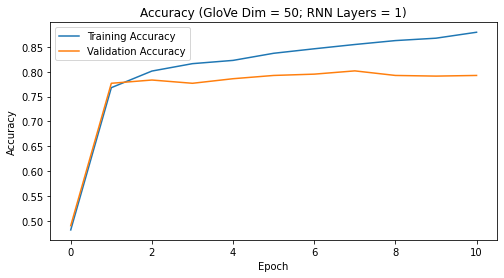

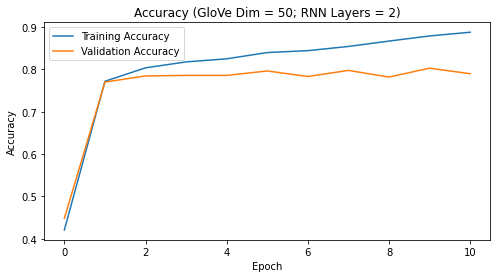

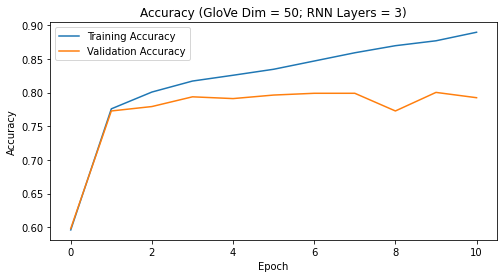

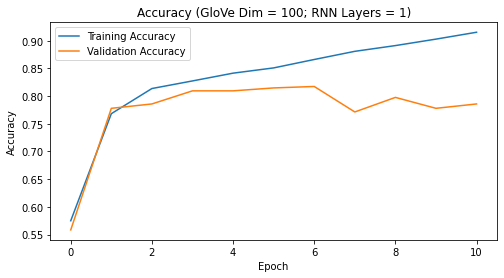

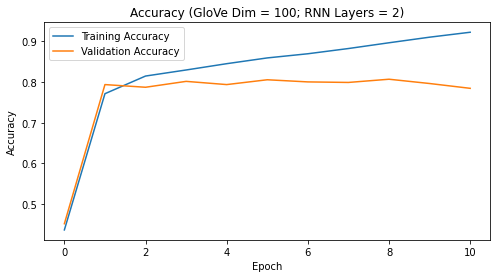

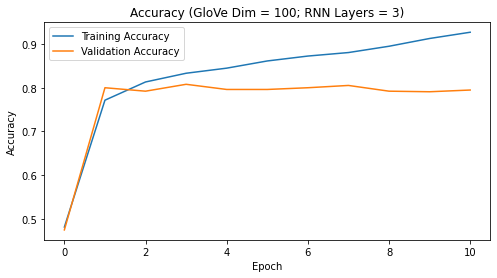

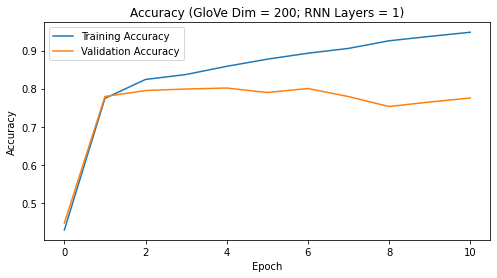

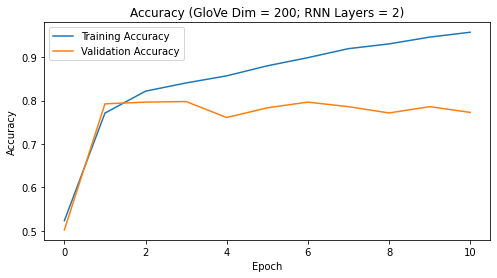

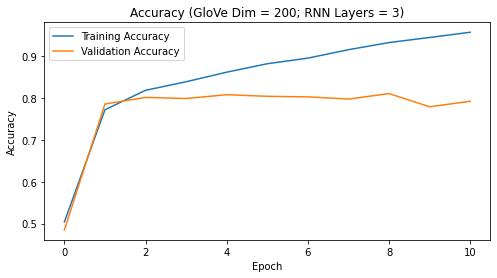

In [19]:
for glove_dim in GLOVE_DIMS:
    for rnn_layers in RNN_LAYERS:
        plt.figure(figsize=(8, 4))
        plt.plot(train_accs[glove_dim][rnn_layers], label='Training Accuracy')
        plt.plot(val_accs[glove_dim][rnn_layers], label='Validation Accuracy')
        plt.title('Accuracy (GloVe Dim = {}; RNN Layers = {})'.format(glove_dim, rnn_layers))
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.savefig('accuracy-{}-{}.png'.format(glove_dim, rnn_layers))
        plt.show()

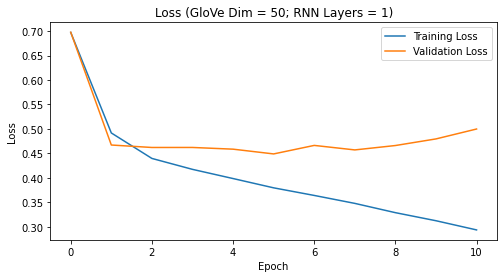

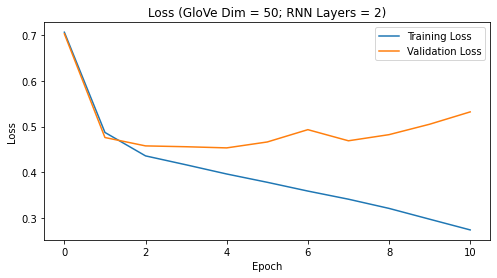

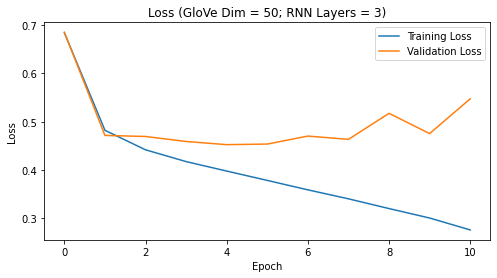

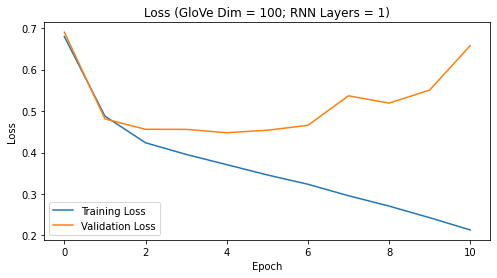

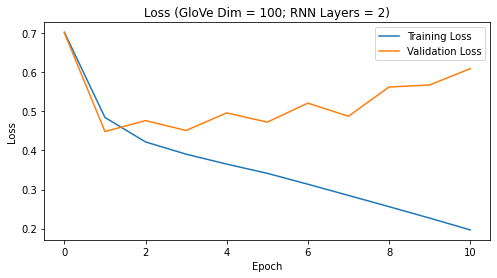

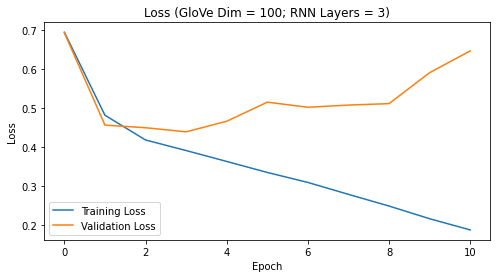

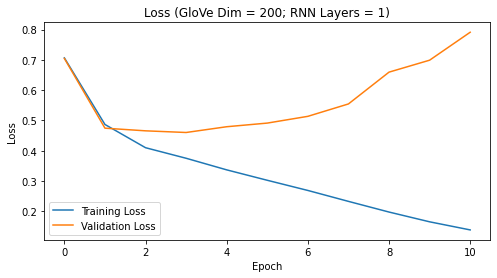

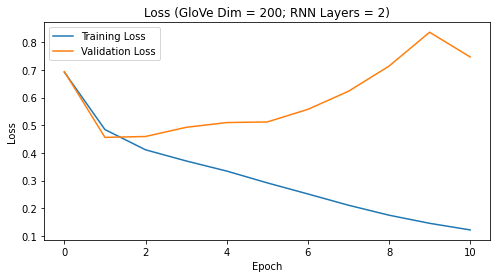

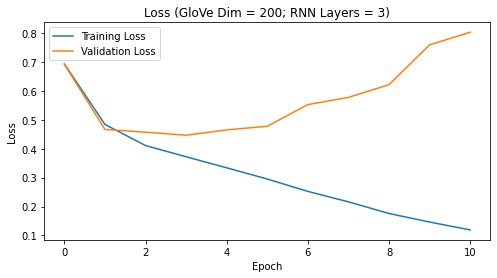

In [20]:
for glove_dim in GLOVE_DIMS:
    for rnn_layers in RNN_LAYERS:
        plt.figure(figsize=(8, 4))
        plt.plot(train_ls[glove_dim][rnn_layers], label='Training Loss')
        plt.plot(val_ls[glove_dim][rnn_layers], label='Validation Loss')
        plt.title('Loss (GloVe Dim = {}; RNN Layers = {})'.format(glove_dim, rnn_layers))
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig('loss-{}-{}.png'.format(glove_dim, rnn_layers))
        plt.show()

In [21]:
test_df = pd.read_csv(TEST_PATH)
for glove_dim in GLOVE_DIMS:
    for rnn_layers in RNN_LAYERS:
        test_predictions = get_predictions(models[glove_dim][rnn_layers], test_dataloader)
        submission = pd.DataFrame(data={'id': test_df['id'], 'target': test_predictions})
        submission.to_csv('submission-{}-{}.csv'.format(glove_dim, rnn_layers), index=False)

100%|██████████| 3263/3263 [00:07<00:00, 437.54it/s]


In [23]:
max_val_acc = 0
best_glove_dim = None
best_rnn_layers = None
for glove_dim in GLOVE_DIMS:
    for rnn_layers in RNN_LAYERS:
        best_val_acc = max(val_accs[glove_dim][rnn_layers])
        print('GloVe dimension: {}\tRNN layers: {}\t Best Validation Accuracy: {}'.format(glove_dim, rnn_layers, best_val_acc))
        
        if best_val_acc > max_val_acc:
            max_val_acc = best_val_acc
            best_glove_dim = glove_dim
            best_rnn_layers = rnn_layers

print()
print('Best GloVe dimension: {}'.format(best_glove_dim))
print('Best RNN Layers: {}'.format(best_rnn_layers))

GloVe dimension: 50	RNN layers: 1	 Best Validation Accuracy: 0.8015768725361366
GloVe dimension: 50	RNN layers: 2	 Best Validation Accuracy: 0.8028909329829172
GloVe dimension: 50	RNN layers: 3	 Best Validation Accuracy: 0.8002628120893561
GloVe dimension: 100	RNN layers: 1	 Best Validation Accuracy: 0.8173455978975033
GloVe dimension: 100	RNN layers: 2	 Best Validation Accuracy: 0.8068331143232589
GloVe dimension: 100	RNN layers: 3	 Best Validation Accuracy: 0.8081471747700394
GloVe dimension: 200	RNN layers: 1	 Best Validation Accuracy: 0.8015768725361366
GloVe dimension: 200	RNN layers: 2	 Best Validation Accuracy: 0.797634691195795
GloVe dimension: 200	RNN layers: 3	 Best Validation Accuracy: 0.8107752956636005

Best GloVe dimension: 100
Best RNN Layers: 1


# Some Examples

In [22]:
print(tweet_data.train_data[:2])

[{'label': 0, 'tokens': ['rockbottomradfm', 'as', 'a', 'kid', 'i', 'remember', 'hearing', 'rules', 'about', '30', 'to', '90', 'days', 'wo', 'a', 'defense', 'and', 'youre', 'stripped', 'brock', 'obliterated', 'that'], 'mapped_tokens': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 4, 16, 17, 18, 1, 19, 20, 21]}, {'label': 0, 'tokens': ['do', 'you', 'feel', 'like', 'you', 'are', 'sinking', 'in', 'low', 'selfimage', 'take', 'the', 'quiz'], 'mapped_tokens': [22, 23, 24, 25, 23, 26, 27, 28, 29, 30, 31, 32, 33]}]
